# Up/Down decon with stochastic gradient algorithms - comparison of torch vs numpy

In this notebook, we want to verify the equivalence of the two implementations

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import torch
import torch.nn as nn

from scipy.sparse import csr_matrix, vstack
from scipy.signal import filtfilt,convolve
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from torch.nn import MSELoss
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import Dataset, DataLoader

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.tapers               import *
from pylops.utils.signalprocessing     import convmtx
from pylops.basicoperators             import *
from pylops.signalprocessing import *
from pylops.waveeqprocessing.wavedecomposition import *
from pylops.waveeqprocessing.oneway import PhaseShift
from pylops.waveeqprocessing.mdd import MDC, MDD
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import *

from mdc import MDC
from stochmdd_numpy import SGD, ExponentialLR, MDDminibatch
from stochmdd import MDDminibatch as MDDminibatch_torch

## Parameters

In [2]:
datapath = 'Data'

vel_dir = 1500.0 # velocity of water
vel_sep = 1600.0 # velocity at separation level
rho_sep = 1100.0 # density at separation level

method = 'src_ana'
niter = 20

## Data loading

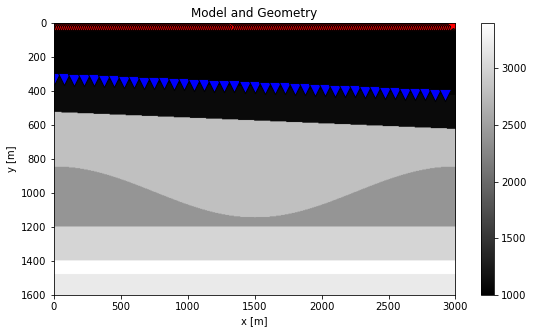

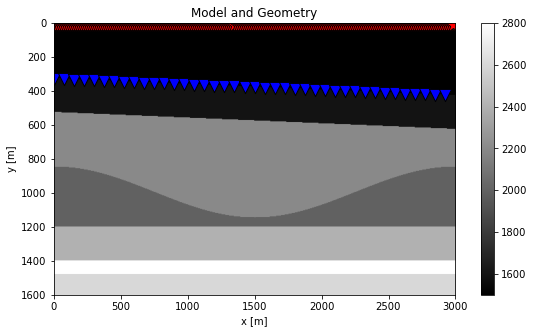

In [3]:
inputfile = os.path.join(datapath, 'input_dipping_recsolid.npz')
inputdata = np.load(inputfile)

# Receivers
r = inputdata['r']
r = r[:, 201:-1]
nr = r.shape[1]
dr = r[0, 1]-r[0, 0]

# Sources
s = inputdata['s']
s = s[:, :200]
ns = s.shape[1]
ds = s[0, 1]-s[0, 0]

# Model
rho = inputdata['rho']
vel = inputdata['vel']

# Axes
nt, dt = 941, 0.005
t = np.arange(nt) * dt
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav, _, wav_c = ricker(t[0:51], 20)
wav_c = np.argmax(wav)

plt.figure(figsize=(9,5))
im = plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(s[0], s[1], marker='*', s=250, c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Model and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

Up/down separated data

In [4]:
data = np.load(os.path.join(datapath, 'updown_dipping_belowseabed_%s.npz'% method))

pup = data['pup'][:200, :, :200]
pdown = data['pdown'][:200, :, :200]

Reference Reflection response

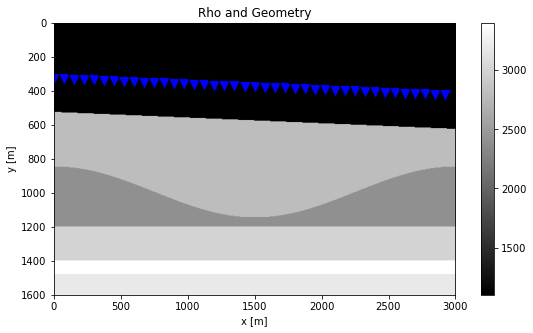

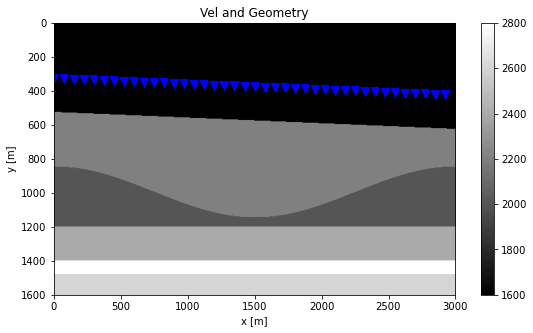

In [5]:
inputfile = os.path.join(datapath, 'input_dipping_noseabed_recsolid.npz')
inputdata = np.load(inputfile)

# data
R = -inputdata['vz_noseabed'][:, :200]

# Model
rho_ref = inputdata['rho_noseabed']
vel_ref = inputdata['vel_noseabed']

plt.figure(figsize=(9,5))
im = plt.imshow(rho_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Rho and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im)

plt.figure(figsize=(9,5))
im = plt.imshow(vel_ref, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(r[0, ::5],  r[1, ::5], marker='v', s=150, c='b', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]'),plt.ylabel('y [m]'),plt.title('Vel and Geometry')
plt.xlim(x[0], x[-1])
plt.ylim(z[-1], z[0])
plt.colorbar(im);

## Data preparation

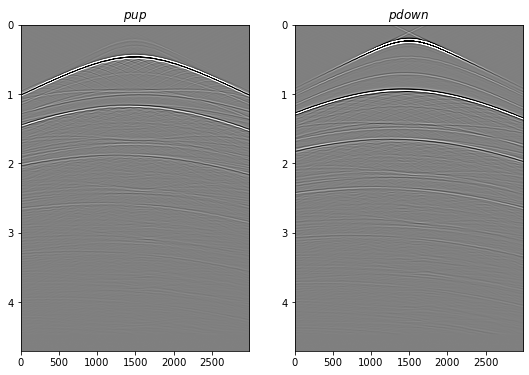

In [6]:
# Pad data with zero at the end (to avoid wrap around)
npad = 50 # 400
pdown = np.pad(pdown, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
pup = np.pad(pup, ((0, 0), (0, npad), (0, 0)))#.astype('float32')
R = np.pad(R, ((1, npad), (0, 0) ))#.astype('float32')
ntpad = pup.shape[1]
tpad = np.arange(ntpad) * dt
tpad2 = np.hstack((-tpad[::-1], tpad[1:]))

fig, axs = plt.subplots(1, 2, figsize=(9,6))
axs[0].imshow(pup[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'$pup$')
axs[0].axis('tight')
axs[1].imshow(pdown[ns//2], cmap='gray', vmin=-0.1*np.abs(pdown).max(), vmax=0.1*np.abs(pdown).max(),
              extent = (r[0,0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'$pdown$')
axs[1].axis('tight');

In [7]:
# Rescale data to of amplitude around 1
scaling = 5
pdown *= scaling
pup *= scaling

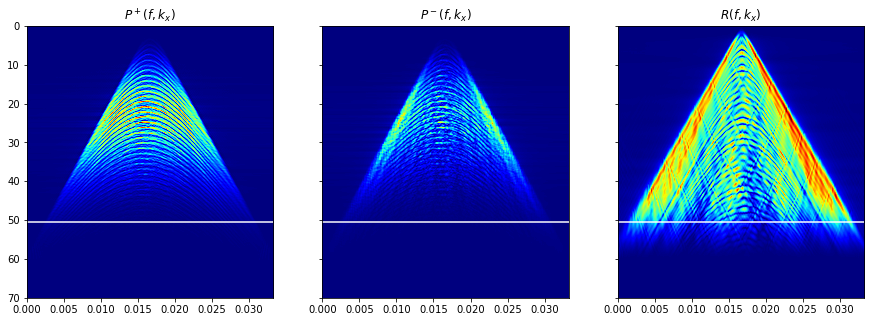

In [8]:
# check max frequency to use
nfmax=250#550
nfft = ntpad#2**11

FFTop = FFT2D(dims=[nr, ntpad], nffts=[nfft, nfft], sampling=[dr, dt])
PUP = (FFTop*pup[ns//2].T.flatten()).reshape(nfft, nfft)
PDOWN = (FFTop*pdown[ns//2].T.flatten()).reshape(nfft, nfft)
RTRUE = (FFTop*R.T.ravel()).reshape(nfft, nfft)

# mask away high freqs
mask = np.zeros((nfft, nfft))
mask[:, :nfmax] = 1
mask[:, -nfmax:] = 1
mask = filtfilt(np.ones(50)/50, 1, mask, axis=1)
RTRUE *= mask
R = np.real(FFTop.H * RTRUE.ravel()).reshape(nr, ntpad).T

fig, axs = plt.subplots(1, 3, sharey=True, figsize=(15,5))
im=axs[0].imshow(np.fft.fftshift(np.abs(PDOWN[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[0].axhline(FFTop.f2[nfmax], color='w')
axs[0].set_title(r'$P^+(f, k_x)$')
axs[0].axis('tight')
im=axs[1].imshow(np.fft.fftshift(np.abs(PUP[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(PDOWN).max())
axs[1].axhline(FFTop.f2[nfmax], color='w')
axs[1].set_title(r'$P^-(f, k_x)$')
axs[1].axis('tight')
im=axs[2].imshow(np.fft.fftshift(np.abs(RTRUE[:, :nfft//2-1]),axes=0).T, cmap='jet', interpolation='sinc',
                 extent = (FFTop.f1[0], FFTop.f1[nfft//2-1], FFTop.f2[nfft//2-1], FFTop.f2[0]),
                 vmin=0, vmax=np.abs(RTRUE).max())
axs[2].axhline(FFTop.f2[nfmax], color='w')
axs[2].set_title(r'$R(f, k_x)$')
axs[2].axis('tight')
axs[2].set_ylim(70, 0);

## Stochastic MDD

In [9]:
lossdict = {}
lossepochdict = {}
avgdict = {}
enormdict = {}
gnormdict = {}
mdict = {}
dr = 1. # force it to 1

In [10]:
pup = pup[:, :, nr//2].T
pdown = np.swapaxes(pdown, 2, 1)

In [11]:
pdown_fft = np.fft.rfft(pdown, ntpad, axis=-1)
pdown_fft = pdown_fft[...,:nfmax]
pdown_fft = pdown_fft.transpose(2,0,1)

In [12]:
# Torch
R_torch= torch.from_numpy(R)
pdown_fft_torch = torch.from_numpy(pdown_fft)
pup_torch = torch.from_numpy(pup)

### Gradients

Initial Loss norm: 1.153848e-02
Initial Gradient norm: 1.423951e-04, scaled by lr: 1.423951e-04
Time: 0.426344 s
Initial Gradient norm: 2.276022e-03, scaled by lr: 2.276022e-03
Initial Gradient norm as np.linalg.norm: 4.727831e+03, scaled by nbatches:  4.727831e+03
Final Model norm: 2.276022e-03
Time: 0.857079 s


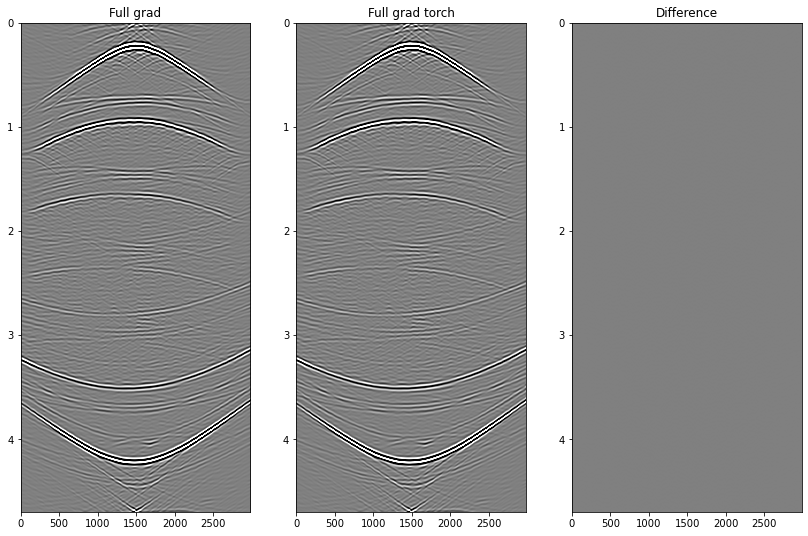

In [13]:
# Check full gradient
gradfull = MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                        1, ns, twosided=False, mtrue=R, seed=0, savegradnorm=True, savefirstgrad=True,
                        **dict(lr=1., weight_decay=0))[-1].reshape(ntpad, nr)

gradfull_torch = MDDminibatch_torch(ntpad, nr, dt, dr, pdown_fft_torch, pup_torch, torch.optim.SGD, 
                        1, ns, twosided=False, mtrue=R_torch, seed=0, savegradnorm=True, savefirstgrad=True,
                        **dict(lr=1., weight_decay=0))[-1].reshape(ntpad, nr)
torch_to_numpy_to_scaling =  ((ntpad*ns)/2) 
gradfull_torch = gradfull_torch * torch_to_numpy_to_scaling

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
axs[0].imshow(gradfull, cmap='gray', vmin=-0.1*np.abs(gradfull).max(), vmax=0.1*np.abs(gradfull).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'Full grad')
axs[0].axis('tight')
axs[1].imshow(gradfull_torch, cmap='gray', vmin=-0.1*np.abs(gradfull).max(), vmax=0.1*np.abs(gradfull).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'Full grad torch')
axs[1].axis('tight')
axs[2].imshow(gradfull - gradfull_torch.cpu().numpy(), cmap='gray', vmin=-0.1*np.abs(gradfull).max(), vmax=0.1*np.abs(gradfull).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'Difference')
axs[2].axis('tight');

Initial Loss norm: 8.191437e-03
Initial Gradient norm: 1.096322e-05, scaled by lr: 1.096322e-05
Time: 0.476345 s
Initial Gradient norm: 6.845103e-03, scaled by lr: 6.845103e-03
Initial Gradient norm as np.linalg.norm: 1.311848e+03, scaled by nbatches:  8.199052e+03
Final Model norm: 8.600009e-02
Time: 0.858366 s


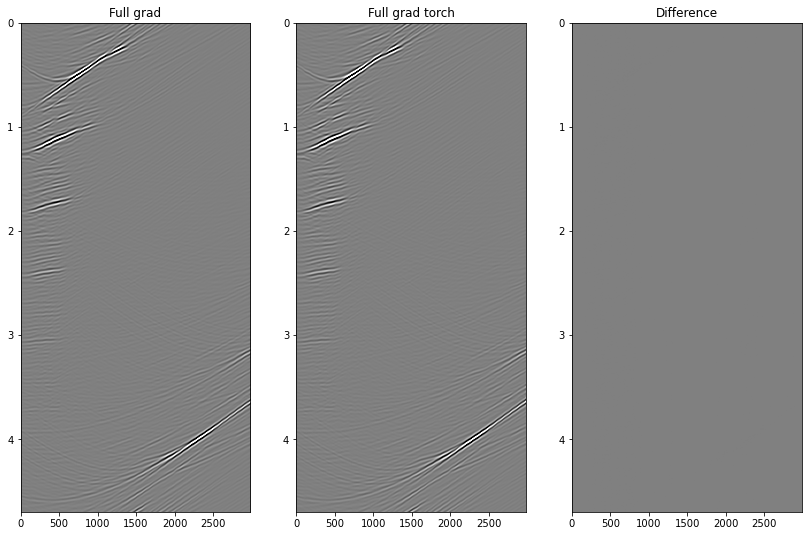

In [14]:
# Check Batch
batch_size = 32

grad32 = MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                      1, batch_size, twosided=False, shuffle=False, mtrue=R, seed=0, savegradnorm=True, savefirstgrad=True,
                      **dict(lr=1., weight_decay=0))[-1].reshape(ntpad, nr)

grad32_torch = MDDminibatch_torch(ntpad, nr, dt, dr, pdown_fft_torch, pup_torch, torch.optim.SGD, 
             1, batch_size, twosided=False, shuffle=False, mtrue=R_torch, seed=0, savegradnorm=True, savefirstgrad=True,
             **dict(lr=1., weight_decay=0))[-1].reshape(ntpad, nr)
torch_to_numpy_to_scaling =  ((ntpad*batch_size)/2) 
grad32_torch = grad32_torch * torch_to_numpy_to_scaling

fig, axs = plt.subplots(1, 3, figsize=(14, 9))
axs[0].imshow(grad32, cmap='gray', vmin=-0.1*np.abs(gradfull).max(), vmax=0.1*np.abs(gradfull).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[0].set_title(r'Full grad')
axs[0].axis('tight')
axs[1].imshow(grad32_torch, cmap='gray', vmin=-0.1*np.abs(gradfull).max(), vmax=0.1*np.abs(gradfull).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[1].set_title(r'Full grad torch')
axs[1].axis('tight')
axs[2].imshow(grad32 - grad32_torch.cpu().numpy(), cmap='gray', vmin=-0.1*np.abs(gradfull).max(), vmax=0.1*np.abs(gradfull).max(),
              extent = (r[0, 0], r[0,-1], t[-1], t[0]))
axs[2].set_title(r'Difference')
axs[2].axis('tight');

### GD

Works the same!

In [15]:
batch_size = ns
nepochs = 10
lr_torch = 10.

In [16]:
torch_to_numpy_to_scaling =  ((ntpad*batch_size)/2) 
lr = lr_torch / torch_to_numpy_to_scaling

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                              nepochs, batch_size, twosided=False, shuffle=False,
                              mtrue=R, seed=0, enormabsscaling=True,
                              epochprint=5, savegradnorm=True, 
                              **dict(lr=lr, weight_decay=0))
mdict["SGD"] = model

Initial Loss norm: 1.153848e-02
Initial Gradient norm: 1.423951e-04, scaled by lr: 1.449932e-12
epoch:   5, loss : 1.9283e-03, loss avg : 1.9283e-03
epoch:  10, loss : 9.0352e-04, loss avg : 9.0352e-04
Time: 2.968358 s


In [17]:
model, dmod, lossdict['SGD_torch'], avgdict['SGD_torch'], lossepochdict['SGD_torch'], enormdict['SGD_torch'], _, gnormdict['SGD_torch']= \
                 MDDminibatch_torch(ntpad, nr, dt, dr, pdown_fft_torch, pup_torch, torch.optim.SGD, 
                                    nepochs, batch_size, twosided=False, shuffle=False,
                                    mtrue=R_torch, seed=0, epochprint=5, savegradnorm=True,
                                    **dict(lr=lr_torch, weight_decay=0))
mdict["SGD_torch"] = model.detach().numpy()

Initial Gradient norm: 2.276022e-03, scaled by lr: 2.276022e-01
Initial Gradient norm as np.linalg.norm: 4.727831e+03, scaled by nbatches:  4.727831e+03
epoch:   5, loss : 3.8547e-03, loss avg : 3.8547e-03
epoch:  10, loss : 1.8061e-03, loss avg : 1.8061e-03
Final Model norm: 1.114208e+00
Time: 6.209226 s


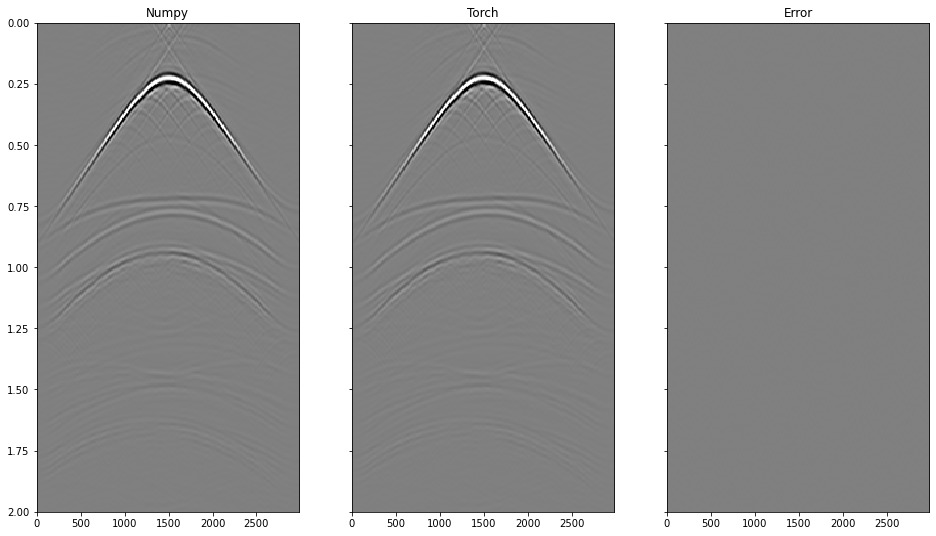

In [18]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(mdict["SGD"], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Numpy')
ax2.imshow(mdict["SGD_torch"], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Torch')
ax3.imshow((mdict["SGD"]-mdict["SGD_torch"]), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.01*np.abs(R).max(), vmax=0.01*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Error')
ax3.set_ylim(2, 0);

### SGD with no shuffle

We get same results provided we rescale the last gradient in numpy implementation to account for the fact that we may not have the entire batch.

In [19]:
batch_size = 64
nepochs = 10
lr_torch = 3.

In [20]:
torch_to_numpy_to_scaling = (ntpad*batch_size)/2
lr = lr_torch / torch_to_numpy_to_scaling

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                              nepochs, batch_size, twosided=False, shuffle=False,
                              mtrue=R, seed=0, enormabsscaling=True,
                              epochprint=5, savegradnorm=True, 
                              **dict(lr=lr, weight_decay=0))
mdict["SGD"] = model

Initial Loss norm: 1.143219e-02
Initial Gradient norm: 4.443183e-05, scaled by lr: 3.976395e-13
epoch:   5, loss : 5.5258e-03, loss avg : 4.6166e-03
epoch:  10, loss : 1.2882e+00, loss avg : 6.3416e-01
Time: 3.559345 s


In [21]:
model, dmod, lossdict['SGD_torch'], avgdict['SGD_torch'], lossepochdict['SGD_torch'], enormdict['SGD_torch'], _, gnormdict['SGD_torch']= \
                 MDDminibatch_torch(ntpad, nr, dt, dr, pdown_fft_torch, pup_torch, torch.optim.SGD, 
                                    nepochs, batch_size, twosided=False, shuffle=False,
                                    mtrue=R_torch, seed=0, epochprint=5, savegradnorm=True,
                                    **dict(lr=lr_torch, weight_decay=0))
mdict["SGD_torch"] = model.detach().numpy()

Initial Gradient norm: 6.935470e-03, scaled by lr: 6.241923e-02
Initial Gradient norm as np.linalg.norm: 2.640959e+03, scaled by nbatches:  8.252996e+03
epoch:   5, loss : 8.8368e-02, loss avg : 2.8559e-02
epoch:  10, loss : 2.0600e+01, loss avg : 5.7739e+00
Final Model norm: 2.046563e+02
Time: 6.539602 s


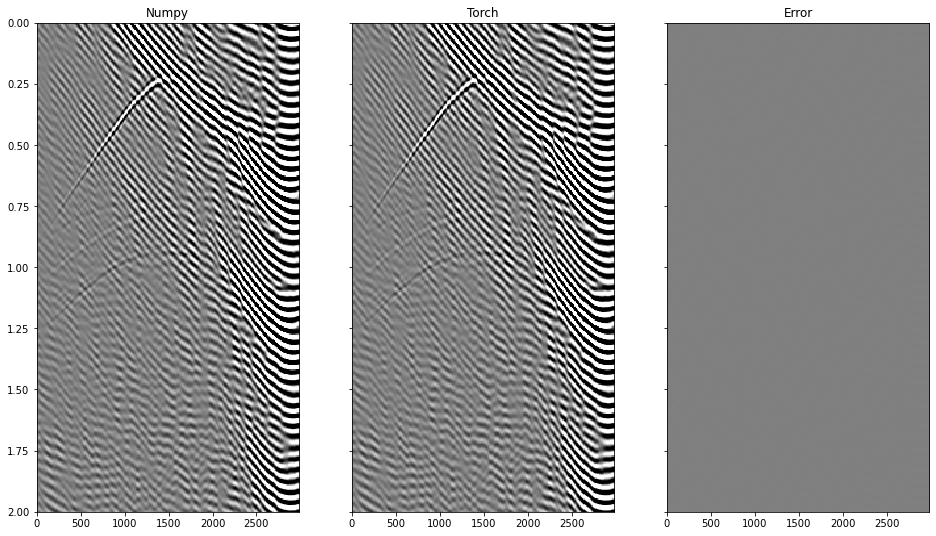

In [22]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(mdict["SGD"], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Numpy')
ax2.imshow(mdict["SGD_torch"], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Torch')
ax3.imshow((mdict["SGD"]-mdict["SGD_torch"]), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.01*np.abs(R).max(), vmax=0.01*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Error')
ax3.set_ylim(2, 0);

### SGD with shuffle

We cant get the same shuffle but from the above we expect these implementations to be equivalent

In [23]:
batch_size = 64
nepochs = 10
lr_torch = 3.

In [24]:
torch_to_numpy_to_scaling = (ntpad*batch_size)/2
lr = lr_torch / torch_to_numpy_to_scaling

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                              nepochs, batch_size, twosided=False, shuffle=True,
                              mtrue=R, seed=0, enormabsscaling=True,
                              epochprint=5, savegradnorm=True, 
                              **dict(lr=lr, weight_decay=0))
mdict["SGD"] = model

model, dmod, lossdict['SGD_torch'], avgdict['SGD_torch'], lossepochdict['SGD_torch'], enormdict['SGD_torch'], _, gnormdict['SGD_torch']= \
                 MDDminibatch_torch(ntpad, nr, dt, dr, pdown_fft_torch, pup_torch, torch.optim.SGD, 
                                    nepochs, batch_size, twosided=False, shuffle=True,
                                    mtrue=R_torch, seed=0, epochprint=5, savegradnorm=True,
                                    **dict(lr=lr_torch, weight_decay=0))
mdict["SGD_torch"] = model.detach().numpy()

Initial Loss norm: 1.159088e-02
Initial Gradient norm: 2.148474e-05, scaled by lr: 1.922761e-13
epoch:   5, loss : 3.2255e-04, loss avg : 1.4416e-03
epoch:  10, loss : 1.1444e-04, loss avg : 6.1696e-04
Time: 3.583614 s
Initial Gradient norm: 3.686200e-03, scaled by lr: 3.317580e-02
Initial Gradient norm as np.linalg.norm: 1.925365e+03, scaled by nbatches:  6.016765e+03
epoch:   5, loss : 3.2337e-03, loss avg : 3.5851e-03
epoch:  10, loss : 1.8397e-03, loss avg : 1.6408e-03
Final Model norm: 1.255848e+00
Time: 6.519878 s


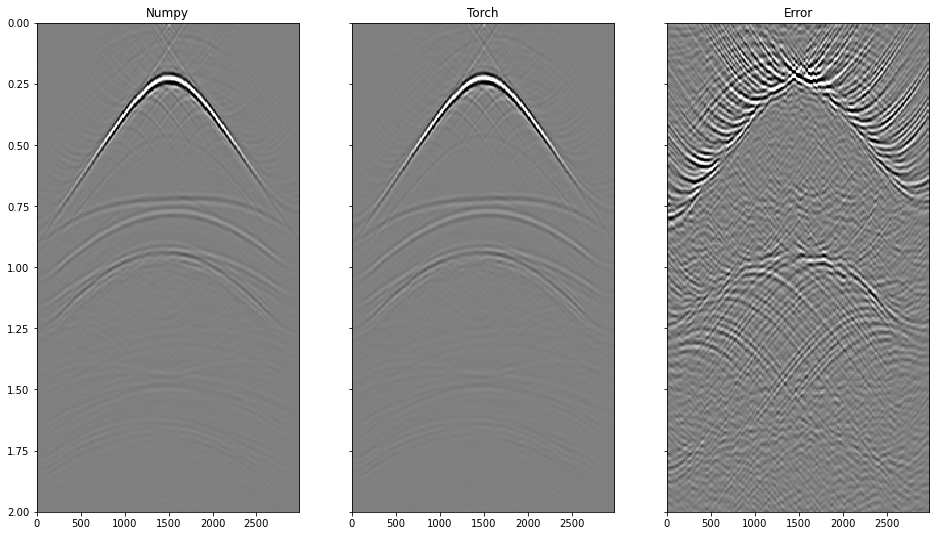

In [25]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(mdict["SGD"], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Numpy')
ax2.imshow(mdict["SGD_torch"], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Torch')
ax3.imshow((mdict["SGD"]-mdict["SGD_torch"]), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.01*np.abs(R).max(), vmax=0.01*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Error')
ax3.set_ylim(2, 0);

### SGD with momentum and no-shuffle

In [26]:
batch_size = 64
nepochs = 10
lr_torch = 0.7

In [27]:
torch_to_numpy_to_scaling = (ntpad*batch_size)/2
lr = lr_torch / torch_to_numpy_to_scaling

model, dmod, lossdict['SGD'], avgdict['SGD'], lossepochdict['SGD'], enormdict['SGD'], _ = \
                 MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                              nepochs, batch_size, twosided=False, shuffle=False,
                              mtrue=R, seed=0, enormabsscaling=True,
                              epochprint=5, savegradnorm=True, 
                              **dict(lr=lr, weight_decay=0, momentum=0.9, nesterov=True))
mdict["SGD"] = model

Initial Loss norm: 1.143219e-02
Initial Gradient norm: 4.443183e-05, scaled by lr: 2.164926e-14
epoch:   5, loss : 2.3374e-03, loss avg : 2.0173e-03
epoch:  10, loss : 3.7220e-02, loss avg : 1.2516e-02
Time: 3.658381 s


In [28]:
model, dmod, lossdict['SGD_torch'], avgdict['SGD_torch'], lossepochdict['SGD_torch'], enormdict['SGD_torch'], _, gnormdict['SGD_torch']= \
                 MDDminibatch_torch(ntpad, nr, dt, dr, pdown_fft_torch, pup_torch, torch.optim.SGD, 
                                    nepochs, batch_size, twosided=False, shuffle=False,
                                    mtrue=R_torch, seed=0, epochprint=5, savegradnorm=True,
                                    **dict(lr=lr_torch, weight_decay=0, momentum=0.9, nesterov=True))
mdict["SGD_torch"] = model.detach().numpy()

Initial Gradient norm: 6.935470e-03, scaled by lr: 3.398380e-03
Initial Gradient norm as np.linalg.norm: 2.640959e+03, scaled by nbatches:  8.252996e+03
epoch:   5, loss : 3.7380e-02, loss avg : 1.2209e-02
epoch:  10, loss : 5.9521e-01, loss avg : 1.5522e-01
Final Model norm: 1.925939e+00
Time: 6.548897 s


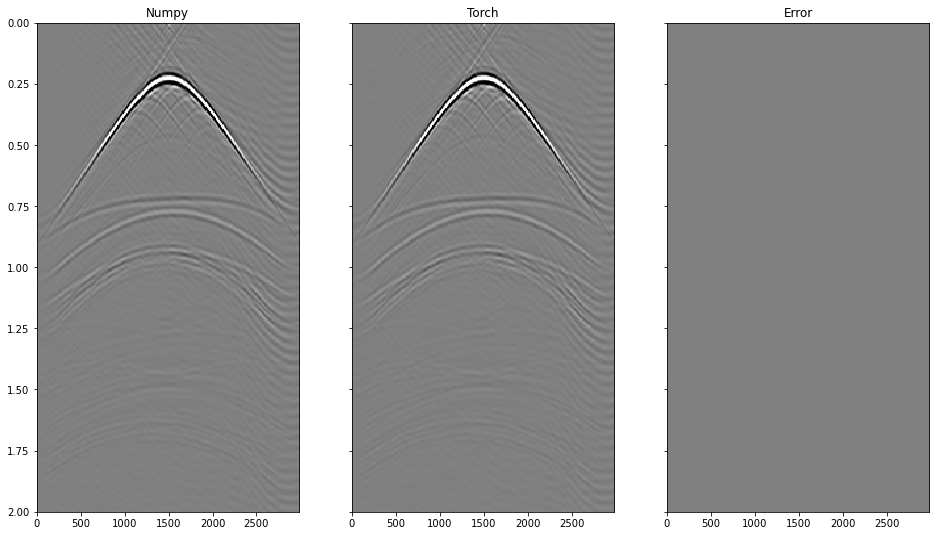

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, sharey=True, figsize=(16, 9))
ax1.imshow(mdict["SGD"], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax1.set_title('Numpy')
ax2.imshow(mdict["SGD_torch"], aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.2*np.abs(R).max(), vmax=0.2*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax2.set_title('Torch')
ax3.imshow((mdict["SGD"]-mdict["SGD_torch"]), aspect='auto', interpolation='nearest', cmap='gray',
           vmin=-0.01*np.abs(R).max(), vmax=0.01*np.abs(R).max(),
           extent = (r[0, 0], r[0,-1], t[-1], t[0]))
ax3.set_title('Error')
ax3.set_ylim(2, 0);

Finally let's take away all 'debugging' computations and see how faster the alg is

In [30]:
_ = MDDminibatch(ntpad, nr, dt, dr, pdown_fft, pup, SGD, 
                 nepochs, batch_size, twosided=False, shuffle=False,
                 mtrue=None, seed=0, enormabsscaling=True,
                 epochprint=5, savegradnorm=False, 
                 **dict(lr=lr, weight_decay=0, momentum=0.9, nesterov=True))

Initial Loss norm: 1.143219e-02
Initial Gradient norm: 4.443183e-05, scaled by lr: 2.164926e-14
epoch:   5, loss : 2.3374e-03, loss avg : 2.0173e-03
epoch:  10, loss : 3.7220e-02, loss avg : 1.2516e-02
Time: 3.632933 s
